# Guiding questions

How does graduate student gender diversity at Columbia compare to its peer institutions?

In [1]:
from collections import defaultdict
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# https://stackoverflow.com/questions/19798112/convert-pandas-dataframe-to-a-nested-dict
def recur_dictify(frame):
    if len(frame.columns) == 1:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.ix[:,1:]) for k,g in grouped}
    return d

def get_dataframe():
    df = pd.read_csv(
        '../../data/GSS_Export_Broad_Sex_RaceEthnicity.csv', 
        thousands=',',
        header=4, # starting at 4th row
        skipfooter=4, # ignore last 4 lines of data (footer)
        engine='python', # default pandas engine does not support skipfooter
        index_col=False, # don't use first column (year) as dataframe index
        names = ['Year', 'Institution Name', 'Broad Fields', 'Sex', 'Race and Ethnicity', 'Total']
    )

    # Delete some aggregate values we don't need for this analysis
    df = df[ df['Institution Name'] != 'Total for selected values' ]
    df = df[ df['Broad Fields'] != 'Total for selected values' ]

    # Rename all instances of 'Columbia Univ in the City of New York'
    # to 'Columbia University in the City of New York'
    df['Institution Name'] = df['Institution Name'].str.replace(
        'Columbia Univ in the City of New York', 
        'Columbia University in the City of New York'
    )    
    return df

try:
    TOTALS = pickle.load( open('../../data/GSS_Export_Broad_Sex_RaceEthnicity.p', 'rb') )
except FileNotFoundError:
    TOTALS = recur_dictify( get_dataframe() )
    with open('../../data/GSS_Export_Broad_Sex_RaceEthnicity.p', 'wb') as f:
        pickle.dump(totals, f)

In [18]:
years = sorted(TOTALS.keys())
institutions = sorted(TOTALS[ max(years) ].keys())
fields = sorted(TOTALS[ max(years) ]['Columbia University in the City of New York'].keys())

print(f'Data set describes years {min(years)} - {max(years)} for the following institutions: {institutions}.')

Data set describes years 1994 - 2016 for the following institutions: ['Brown University', 'Columbia University in the City of New York', 'Cornell University', 'Dartmouth College', 'Duke University', 'Harvard University', 'Massachusetts Institute of Technology', 'Princeton University', 'Stanford University', 'University of Pennsylvania', 'Yale University'].


In [32]:
# Convenient function for making subplots for every institution
def subplots(num=len(institutions)):
    cols = 2
    rows = math.ceil(num / 2)
    return plt.subplots(rows, cols, figsize=(7 * cols, 7 * rows))

def get_proportions(inst, field):
    proportions = []
    for year in years:
        field_stats = TOTALS[year][inst].get(field, None)
        if field_stats is None:
            proportions.append(None)
        else:
            fem_count = field_stats.get('Female', 0)
            if isinstance(fem_count, dict):
                fem_count = fem_count['Total for selected values']
                
            proportions.append(
                fem_count /
                    field_stats['Total for selected values']['Total for selected values']
            )
    return proportions

def compare_field_subplots(field):
    fig, axArr = subplots()
    for i, inst in enumerate(institutions):
        ax = axArr[i // 2, i % 2]
        plot_field(ax, inst, field)
    fig.suptitle(f'{field}')
    fig.tight_layout()

def plot_inst(ax, field, highlight='Columbia University in the City of New York'):
    for inst in institutions:
        if inst == highlight:
            continue
        ax.plot(years, get_proportions(inst, field), label=inst)
    ax.plot(years, get_proportions(highlight, field), label=highlight, linewidth=3, color='black')
    ax.legend()
    ax.set_ylim(top=1, bottom=0)
    ax.set_title(field)

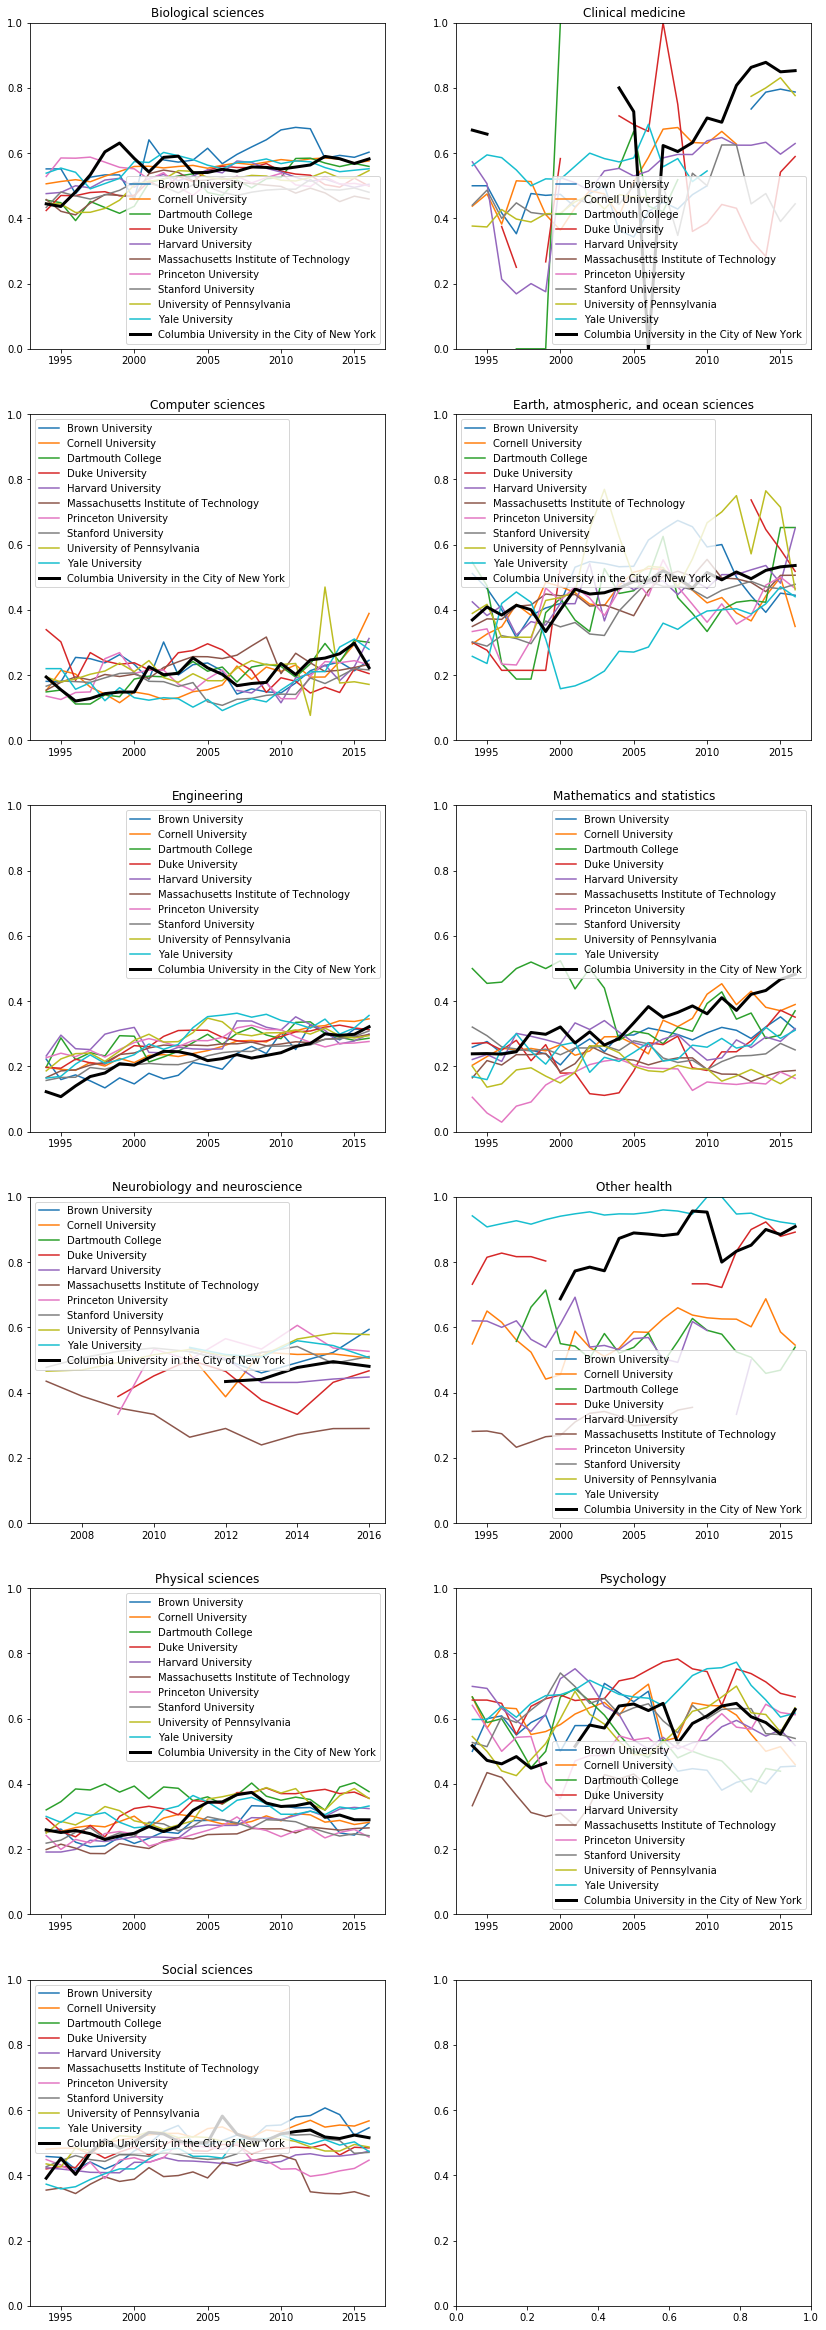

In [33]:
fig, axArr = subplots(len(fields))
for i, field in enumerate(fields):
    ax = axArr[i // 2, i % 2]
    plot_inst(ax, field)

In [11]:
def plot_field(ax, inst, field):
    proportions = get_proportions(inst, field)
    ax.set_title(inst)
    ax.set_ylim(top=1, bottom=0)
    ax.set_xlim(left=min(years), right=max(years))
    ax.plot(years, proportions)

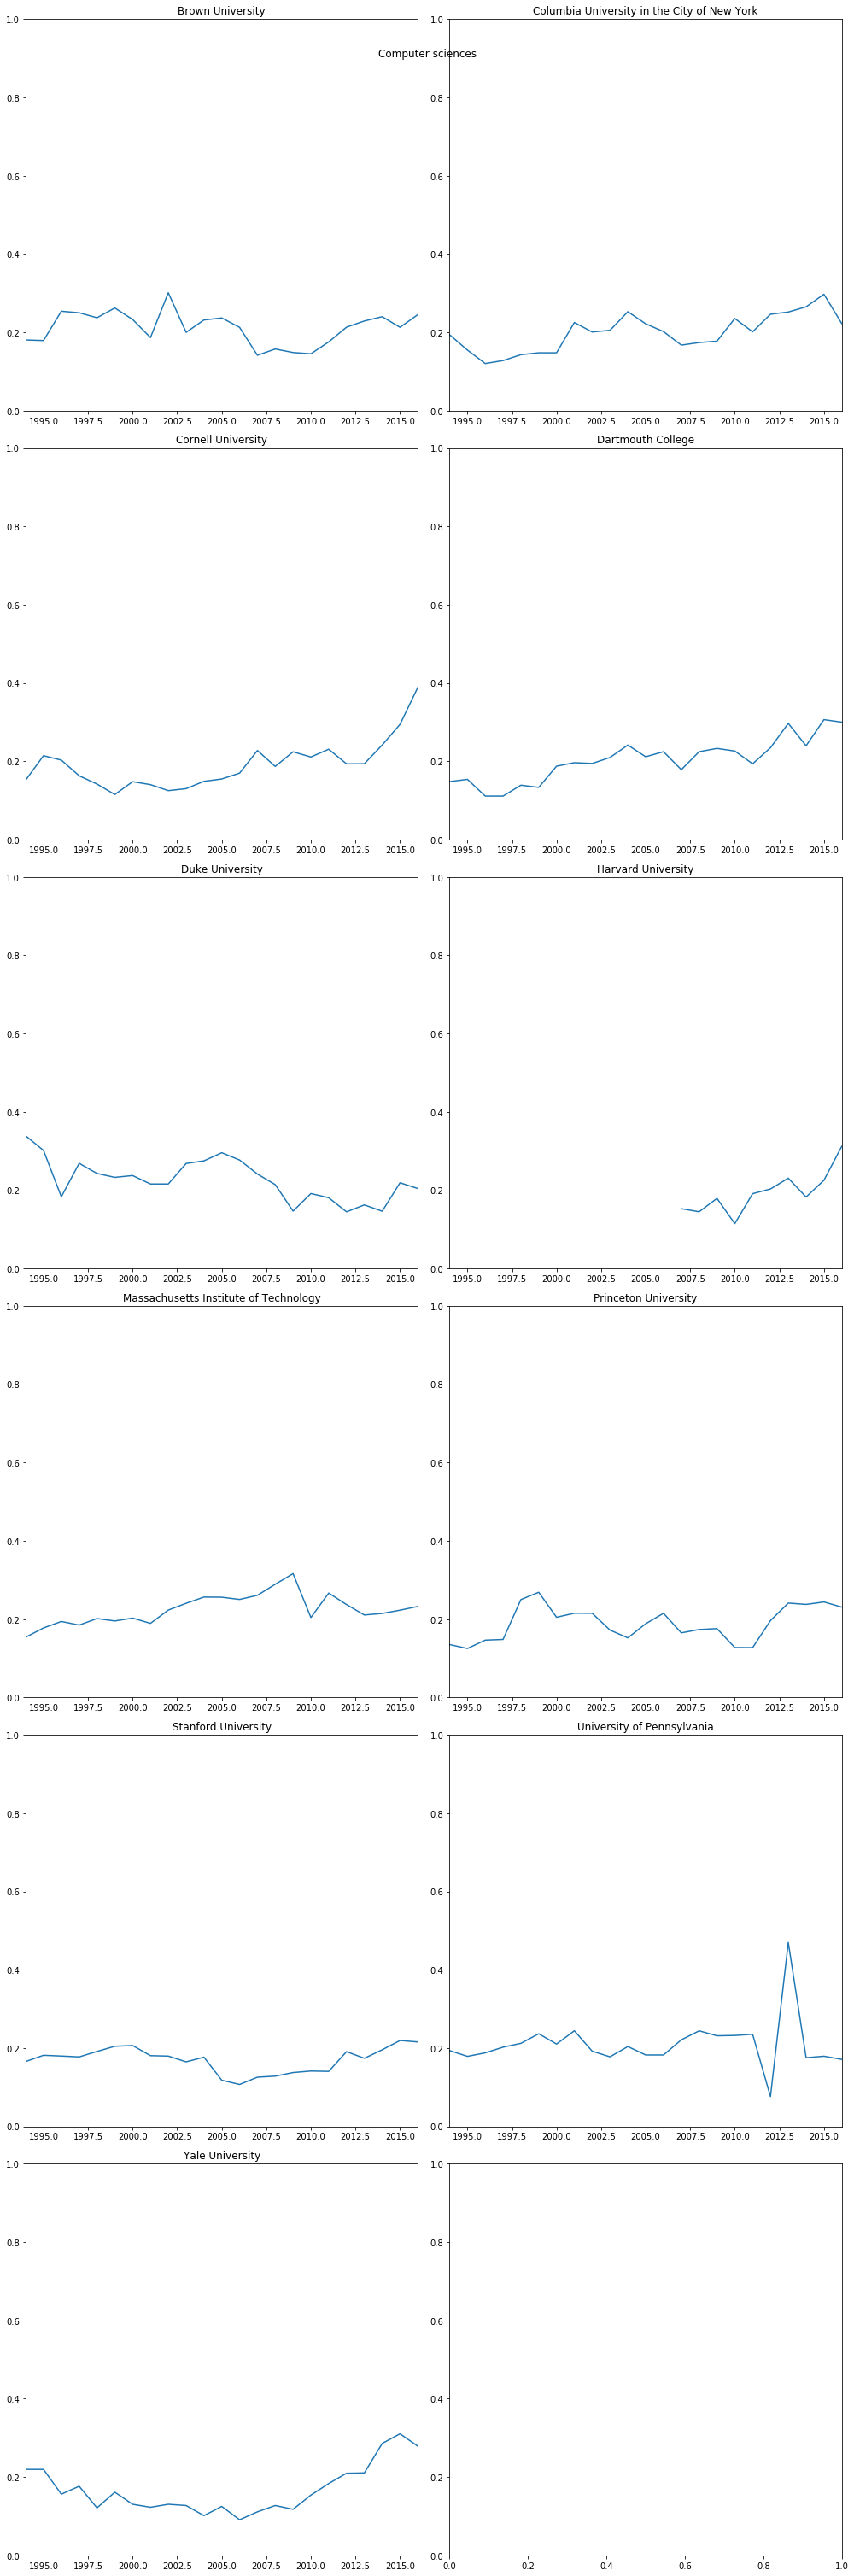

In [17]:
compare_by_field('Computer sciences')